### Environment

In [1]:
from environment import HunterEnvironment
import numpy as np
import torch
import torch.nn as nn

        
def eight_curve_victim_policy(t):
    phi = (2*np.pi)/30*t*0.1/2
    r = 10*2

    x = r * np.sin(phi)
    y = r * np.sin(phi)*np.cos(phi)
    return np.array([x,y])

def ellipse_victim_policy(t):
    phi = (2*np.pi)/30*t*0.1
    r = 10+2*np.sin(phi*2)**2*0

    x = r * np.sin(phi)#+(t/20)
    y = r * np.cos(phi)#+(t/10)
    return np.array([x,y])

### Hunter policy

Since hunter may moove only with speed constrained by some constant, we need to
constrain action space. Let's define max speed as $v_{max}$.
We may define our distribution via some function $G(x)$ from simple normal distribution $\mathcal{N}(x|\mu,diag(e^{2 s}))$.
Let's define function $g(x)$ so, that it was constrained in circle with radius $v_{max}$:
$$
G(x) = v_{max}\frac{x}{||x||_2}e^{-||x||_2^2} 
$$

$$\nabla_x\left[\textbf{f}(x)g(x)\right] = \frac{d\textbf{f}(x)}{dx}g(x)+\frac{dg(x)}{dx} \textbf{f}(x)^T $$

$$ \nabla_x G(x) =v_{max} \left( \frac{e^{-||x||_2^2}}{||x||_2} I + \nabla_x\left[\frac{e^{-||x||_2^2}}{||x||_2}\right]x^T\right) $$

$$ \nabla_x\left[\frac{e^{-||x||_2^2}}{||x||_2}\right] = \nabla_{||x||_2}\left[\frac{e^{-||x||_2^2}}{||x||_2}\right]\nabla_x||x||_2$$

$$\nabla_x||x||_2 = \frac{x}{||x||_2}$$
$$  \nabla_{||x||_2}\left[\frac{e^{-||x||_2^2}}{||x||_2}\right] = -\left[\frac{1}{||x||_2^2}+2\right]e^{-||x||_2^2}$$

$$ \nabla_x G(x) =v_{max}\frac{e^{-||x||_2^2}}{||x||_2} \left(I -\left[\frac{1}{||x||_2^2}+2\right] x x^T\right)  $$

$$\mathcal{J}_{G(x)}=-\left(v_{max} \frac{e^{-||x||_2^2}}{||x||_2}\right)^n \left(1-\left[\frac{1}{||x||_2^2}+2\right]||x||_2^2 \right) = 2\left(v_{max} \frac{e^{-||x||_2^2}}{||x||_2}\right)^n ||x||_2^2 $$

for 2 dimentions:
$$\mathcal{J}_{G(x)}=2 v_{max}^2 e^{-2||x||_2^2}$$

$$\ln(\mathcal{J}_{G(x)}^{-1})=2\left(||x||_2^2-\ln v_{max}\right)-\ln 2$$

So, PDF of distribution rv G(x) may be estimated as following:
$$\mathcal{N}(x|\mu,diag(e^{2s}))J_{G(x)}^{-1}$$

In [2]:
from policy import HunterPolicy
from train import train
%matplotlib inline

env = HunterEnvironment(eight_curve_victim_policy)
policy = HunterPolicy(env)

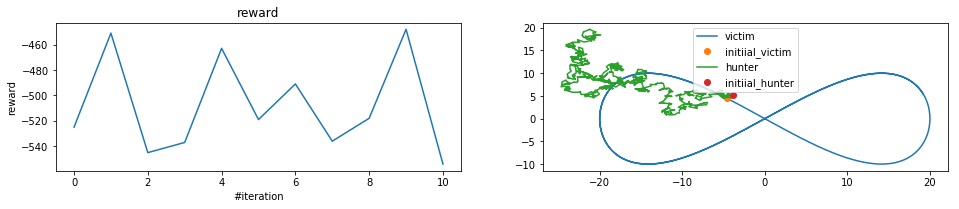

Episode 10	Last length:   999	Last reward: -554.00


KeyboardInterrupt: 

In [3]:
train(policy,env,100000)

In [72]:
torch.save(policy,'eight_curve_policy_speed_3.p')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type HunterPolicy. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [5]:
policy = torch.load('eight_curve_policy_speed_3.p')

### Test Visualization

In [6]:
from visualization import model_hunter_learning

<IPython.core.display.Javascript object>


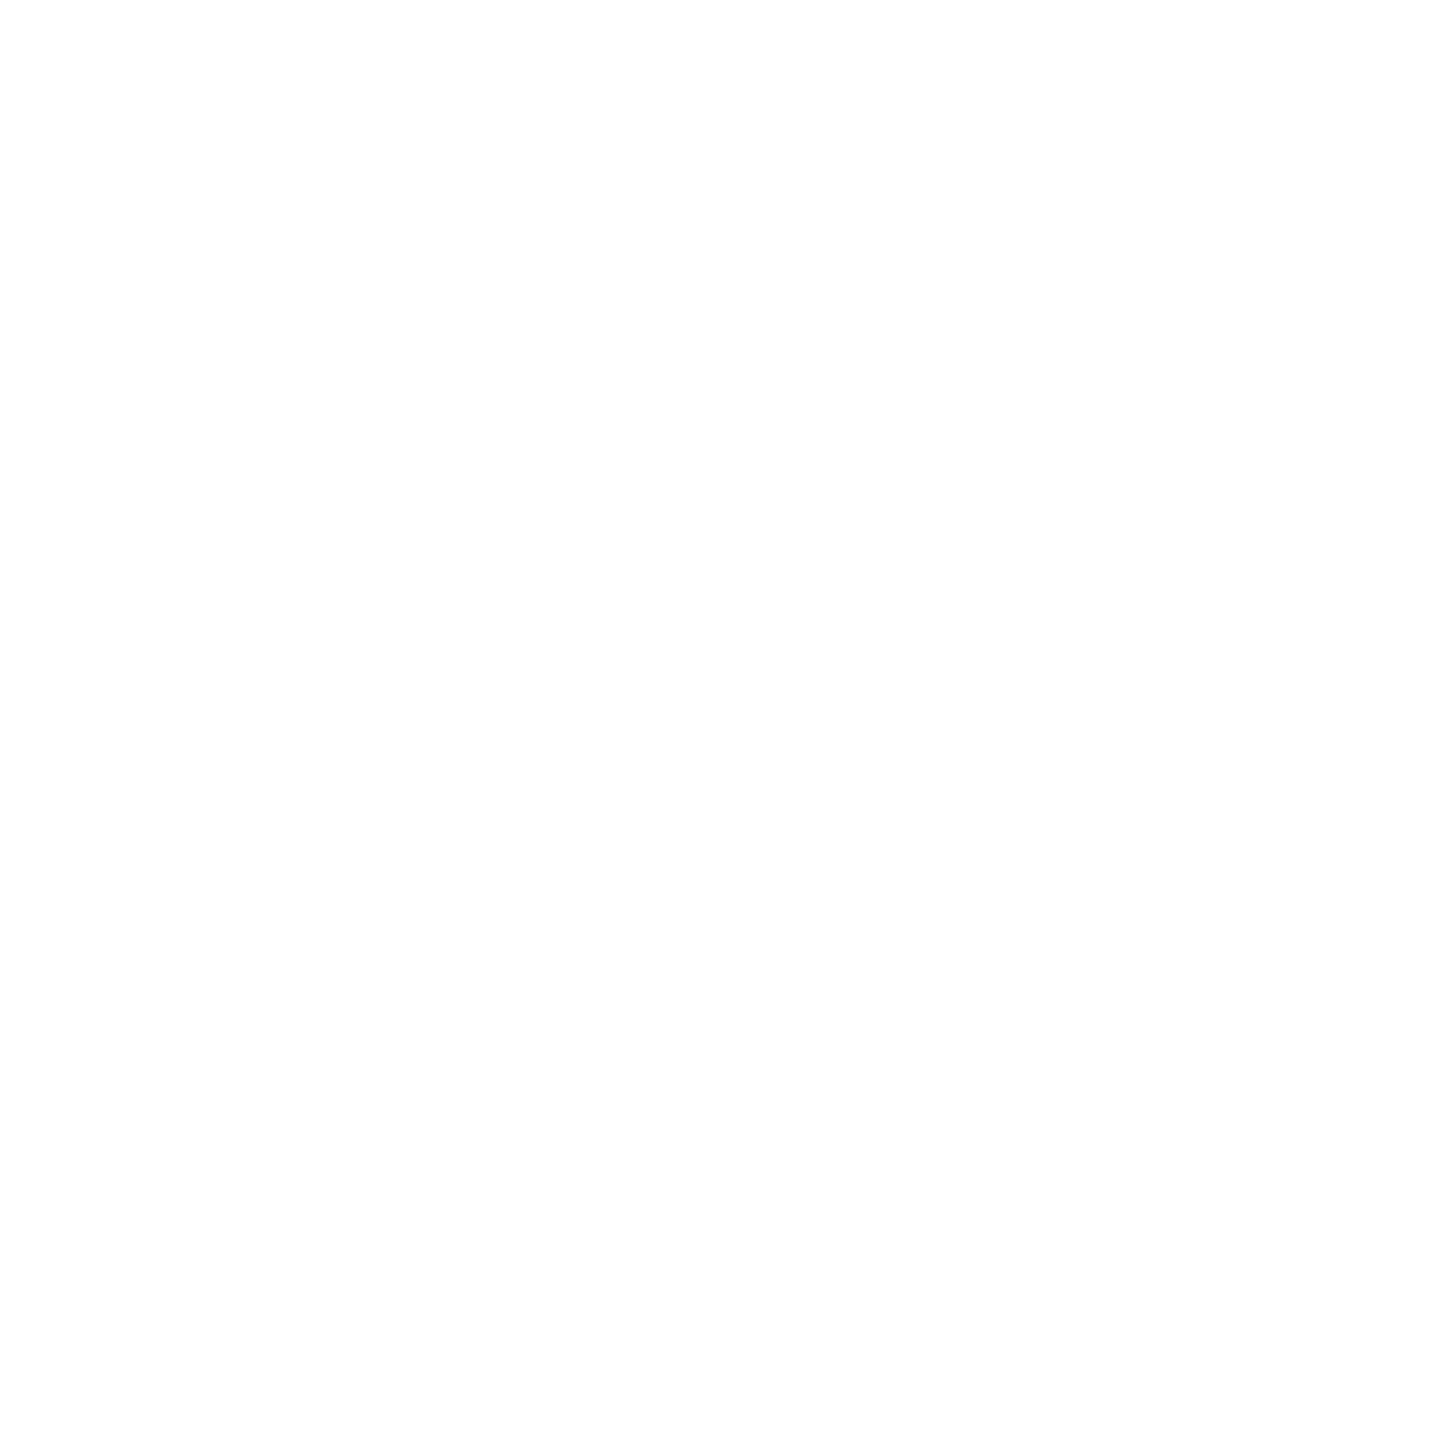

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


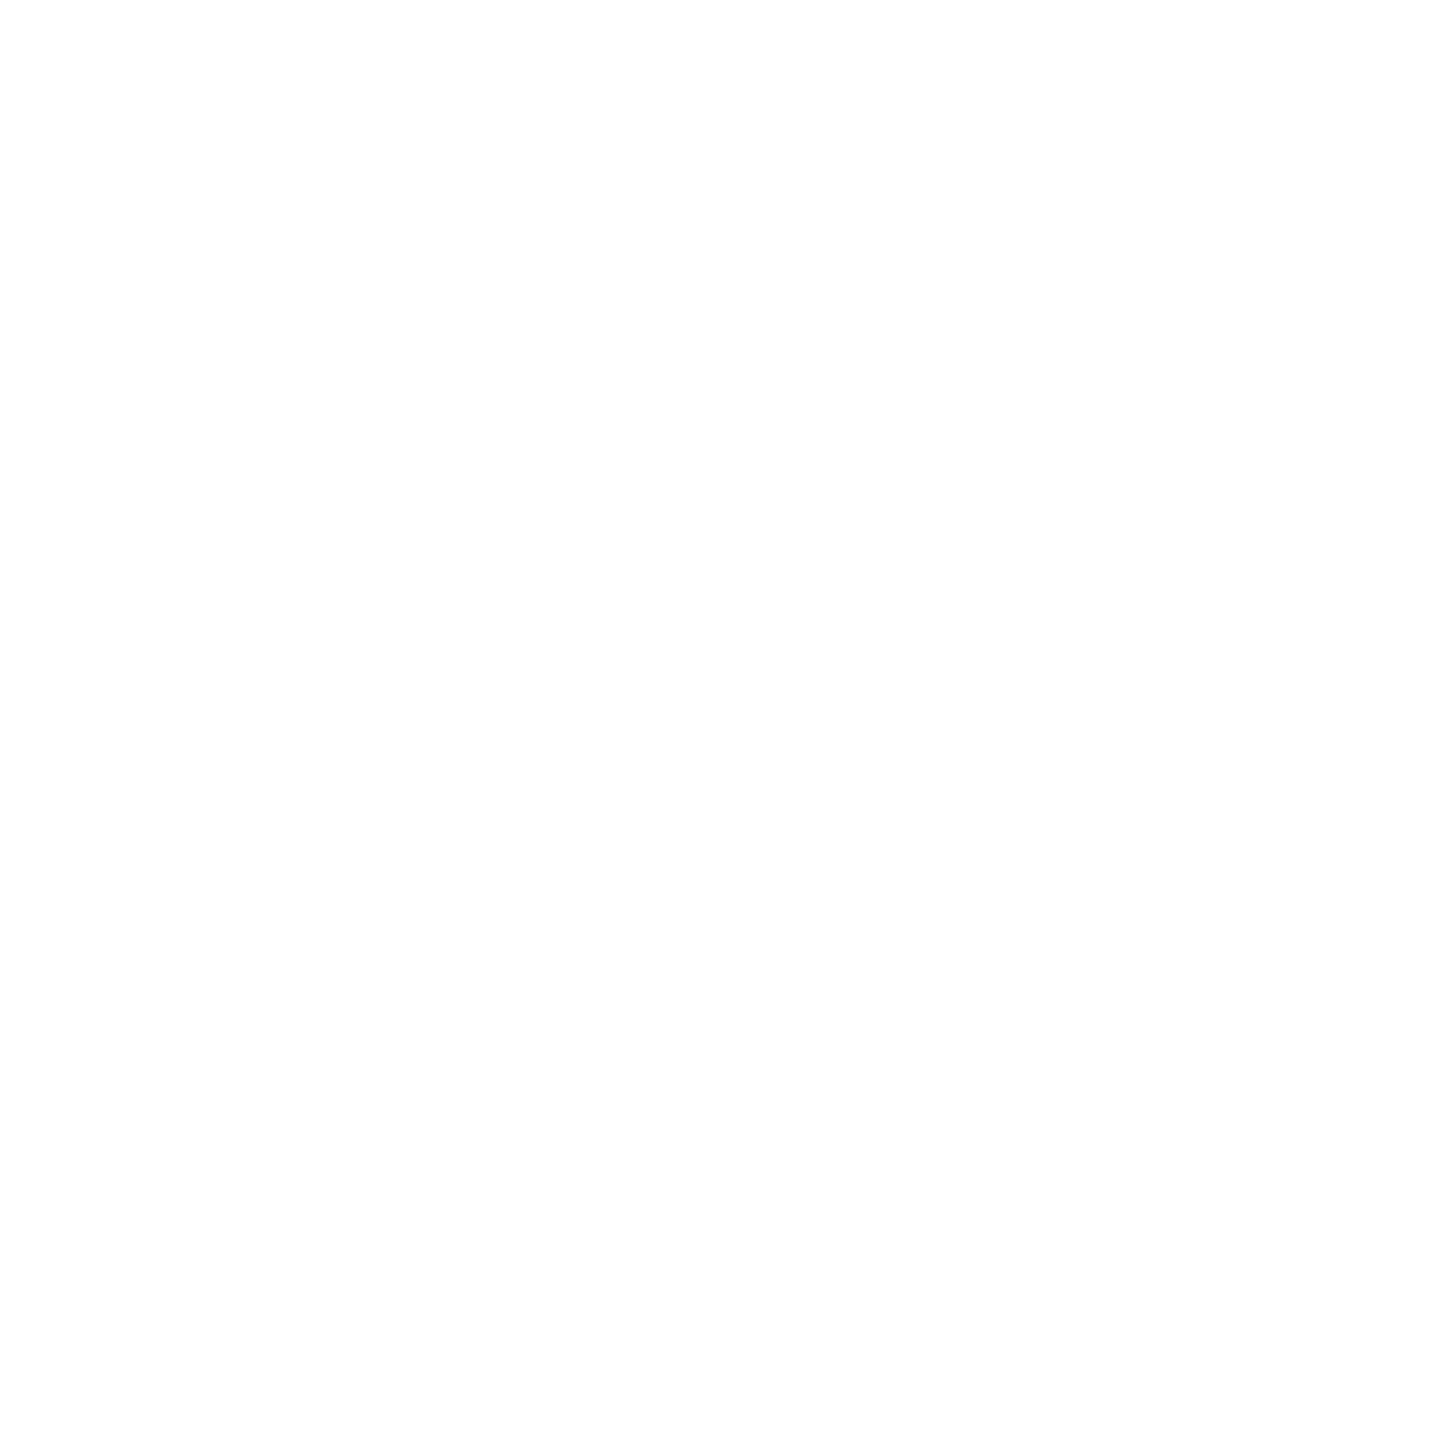

In [15]:
%matplotlib notebook
model_hunter_learning('Test. max speed = 3',policy,eight_curve_victim_policy,hunter_start_position=[0,0])